In [27]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Machine Learning models for Exam Project

## Libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
WAC = lambda x: np.average(x.fillna(0), weights=Data.loc[x.index,'numAttended'])
#from sklearn.model_selection import GridSearchCVb

In [3]:
def accuracy(prediction,test): #Function that calculates accuracy measure based on predicted values and the test set
    errors = abs(prediction - test_labels)
    mape_temp = 100 * abs(errors / test_labels)
    mape=np.mean(mape_temp[~np.isinf(mape_temp)])
    accuracy=100-mape
    MSE=np.mean(np.square(errors))
    print('MAE:', round(np.mean(errors), 5), 'grades.')
    print('MAPE:', round(mape, 5), '%.')
    print('Accuracy:', round(accuracy, 5), '%.')
    print('MSE:', round(MSE, 5))

## Import and clean Data

In [4]:
pd.set_option('display.max_columns',50)
Data=pd.read_csv('KUstatsMerged.csv')
Data=Data.dropna(subset=['GPA']) #only using courses with grades not pass/fail
Input_values=Data[['courseID','faculty','department','term','credit','type'\
                   ,'GPA','movingAverage','Type of assessment','Level','Study board','Censorship form']\
                  +Data.columns.tolist()[-11:]] #Taking all features we want to use for predicting
Output_values=np.array(Input_values['GPA'])#Label values over in a vector
Input_values=Input_values.drop(['term','department','courseID','Level','GPA'], axis=1) #Dropping more unescessary values from input
Input_values.movingAverage.fillna(WAC(Data['GPA']), inplace=True) #Replacing lack of prior course GPA, with the overall weighted average
Input_values=pd.get_dummies(Input_values) #Turning categorical columns into dummy variables
Input_values_list = list(Input_values.columns) #Saving columns header

Input_values = np.array(Input_values) #turning dataframe into array
#splitting into training and test set - note that random_state=42 to be able to replicate results
train_features, test_features, train_labels, test_labels = train_test_split(Input_values, Output_values, test_size = 0.25, random_state = 42)
#Printing sizes to make sure they are the same size
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (10308, 98)
Training Labels Shape: (10308,)
Testing Features Shape: (3436, 98)
Testing Labels Shape: (3436,)


## OLS Regression

In [5]:
#Scaling data
scaler=StandardScaler().fit(train_features)
sc_train_features=scaler.transform(train_features)
sc_test_features=scaler.transform(test_features)

In [6]:
#Fitting and OLS model on the training data
ols=linear_model.LinearRegression()
ols.fit(sc_train_features,train_labels)

LinearRegression()

In [7]:
#predicting using the trained OLS, and calculating the models accuracy
predict_ols = ols.predict(sc_test_features)
accuracy(predict_ols, test_labels)

MAE: 1.18517 grades.
MAPE: 25.73757 %.
Accuracy: 74.26243 %.
MSE: 2.44811


In [8]:
print(predict_ols)
print(test_labels)

[ 6.63201262  8.50701262 10.215997   ...  8.12810637  6.00310637
  7.33904387]
[ 7.8  5.3 10.8 ... 10.   6.1  7.5]


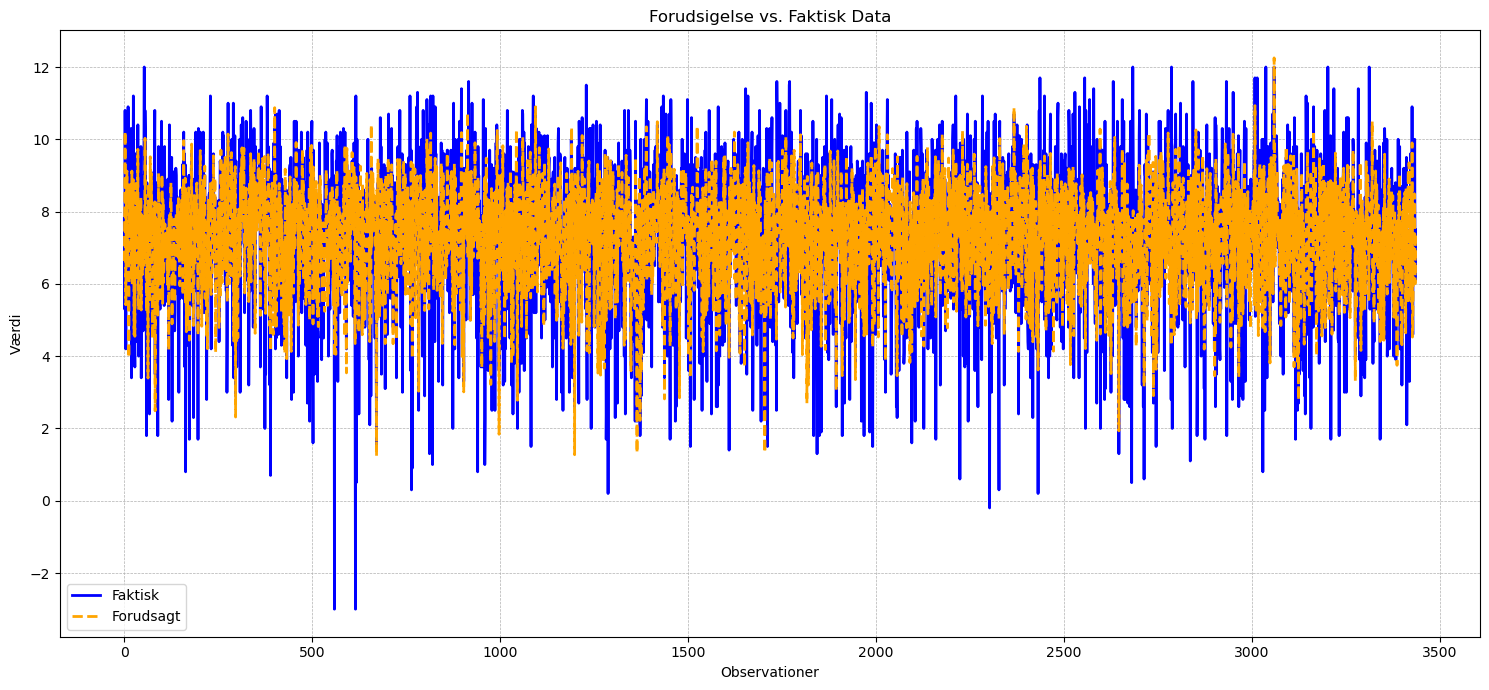

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Opret en række numre for x-aksen baseret på længden af dataene
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Faktisk', color='blue', linewidth=2)
plt.plot(x_axis, predict_ols, label='Forudsagt', color='orange', linestyle='--', linewidth=2)
plt.title('Forudsigelse vs. Faktisk Data')
plt.xlabel('Observationer')
plt.ylabel('Værdi')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Lasso

In [10]:
#Training/fitting the lasso model and predict using the standardized alpha (hyperparameter lambda in report)
lasso_reg=Lasso()
lasso_reg.fit(sc_train_features,train_labels)
lasso_predict=lasso_reg.predict(sc_test_features)
accuracy(lasso_predict, test_labels)

MAE: 1.62839 grades.
MAPE: 37.01997 %.
Accuracy: 62.98003 %.
MSE: 4.21453


In [11]:
#Using gridsearch to find optimal size of hyperparameter
lasso_reg=Lasso()
param_grid={'alpha':np.logspace(-4,4,12)}
grid_search_lasso = GridSearchCV(estimator = lasso_reg, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search_lasso.fit(sc_train_features,train_labels)
grid_search_lasso.best_params_

Fitting 5 folds for each of 12 candidates, totalling 60 fits


{'alpha': 0.002848035868435802}

In [12]:
#Fitting the new model with the above optimal hyperparameter, predicting and calculating accuracy
best_grid_lasso = grid_search_lasso.best_estimator_
predictions_best_grid_lasso = best_grid_lasso.predict(sc_test_features)
accuracy(predictions_best_grid_lasso, test_labels)

MAE: 1.18381 grades.
MAPE: 25.70757 %.
Accuracy: 74.29243 %.
MSE: 2.44678


### Plot of Lasso predictions

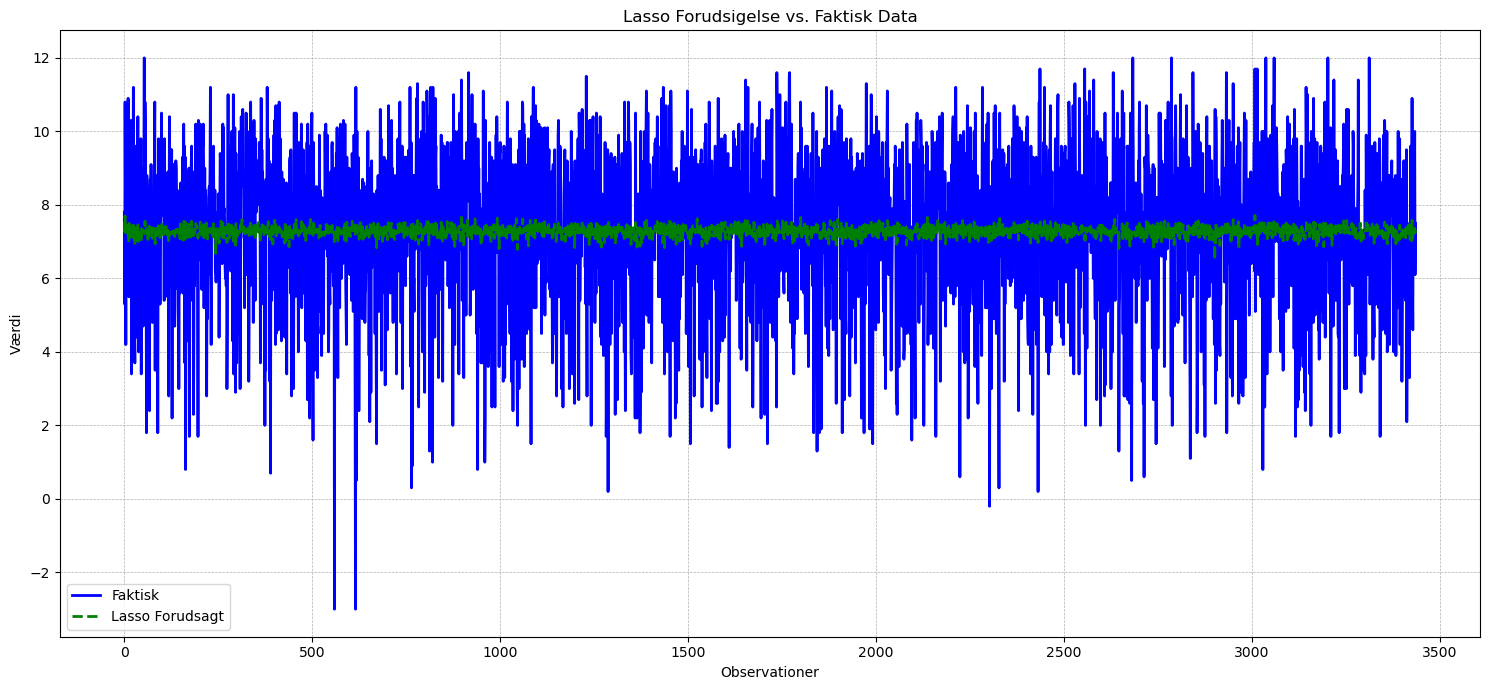

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Opret en række numre for x-aksen baseret på længden af dataene
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Faktisk', color='blue', linewidth=2)
plt.plot(x_axis, lasso_predict, label='Lasso Forudsagt', color='green', linestyle='--', linewidth=2)
plt.title('Lasso Forudsigelse vs. Faktisk Data')
plt.xlabel('Observationer')
plt.ylabel('Værdi')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Coefficients from Lasso

In [25]:
# Hent koefficienterne fra den optimale Lasso-model
lasso_coefficients = best_grid_lasso.coef_

# Opret en DataFrame for bedre læsbarhed
coeff_df_lasso = pd.DataFrame(lasso_coefficients, Input_values_list, columns=['Coefficient'])

coeff_df_lasso

,Coefficient
credit,-0.000000
movingAverage,0.762697
Tutoring,0.000000
Lectures,-0.095758
Preparation,-0.000000
...,...
Study board_The Study Board for Public Health Science and Global\r\nHealth,0.044650
Study board_The Study Board for Veterinary Medicine and Animal\r\nScience,0.028424
Study board_Økonomisk Studienævn,-0.120840
Censorship form_External censorship,-0.000000


) missing from current font.
  plt.tight_layout()
) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


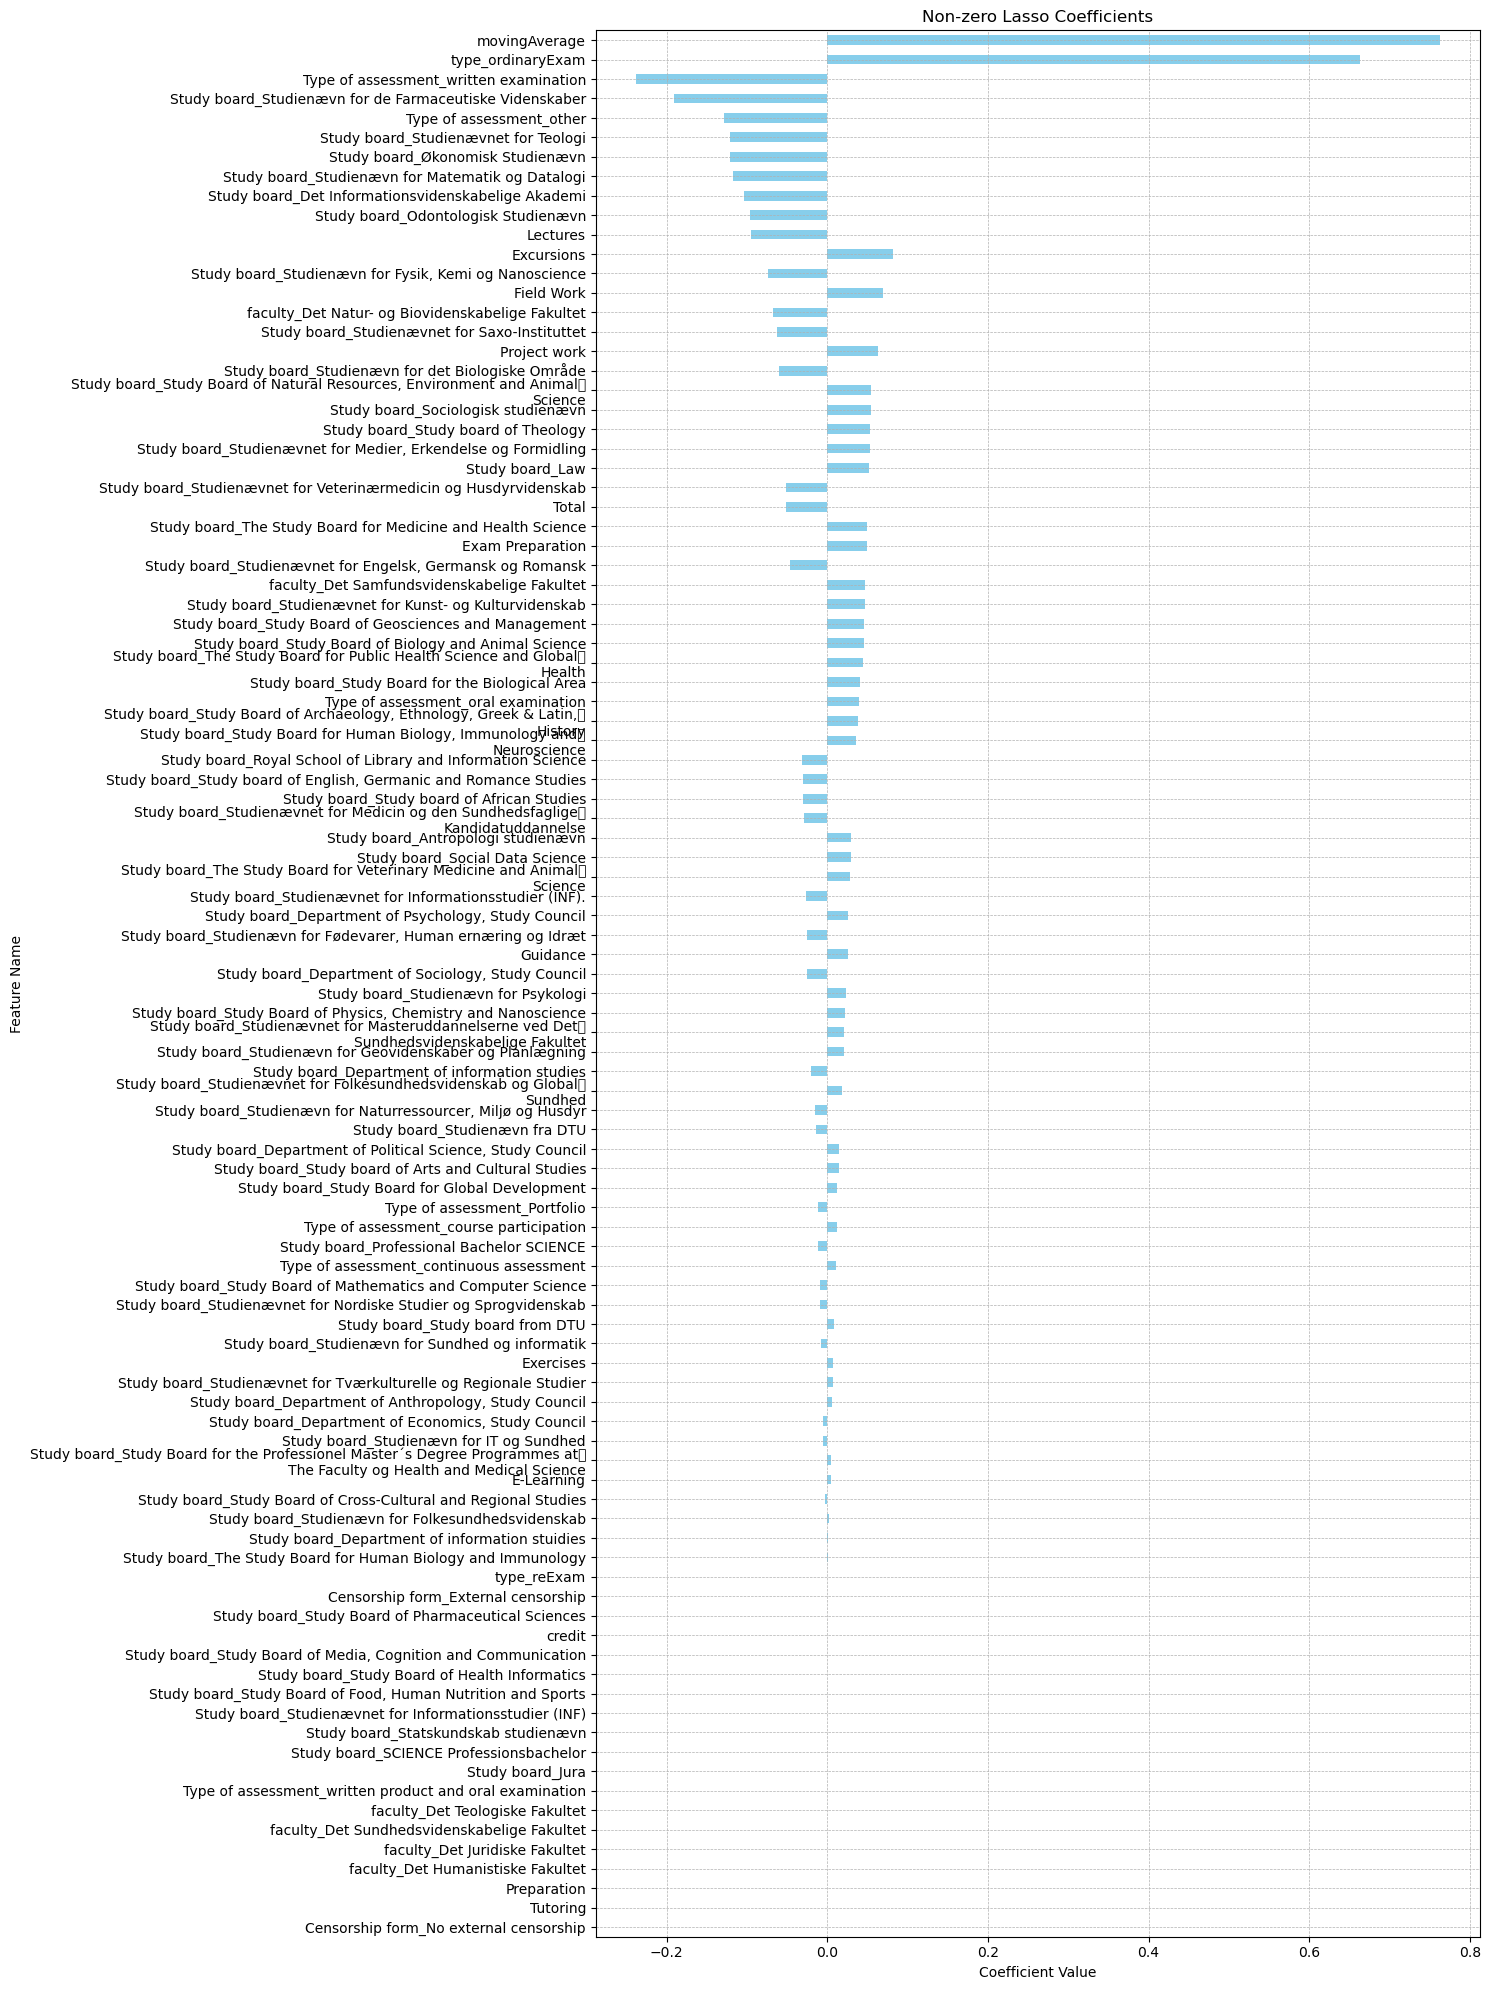

In [33]:
# Filter out zero coefficients
non_zero_coeffs = coeff_df_lasso

# Sort coefficients by absolute value for better visualization
sorted_coeffs = non_zero_coeffs.sort_values(by='Coefficient', key=lambda x: abs(x), ascending=False)

# Plot
plt.figure(figsize=(15,20))
sorted_coeffs['Coefficient'].plot(kind='barh', color='skyblue')
plt.title('Non-zero Lasso Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis()  # This will display the largest coefficients at the top
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Ridge

In [15]:
#Training/fitting the Ridge model and predict using the standardized alpha (hyperparameter lambda in report)
Ridge_reg=Ridge()
Ridge_reg.fit(sc_train_features,train_labels)
Ridge_predict=Ridge_reg.predict(sc_test_features)
accuracy(Ridge_predict, test_labels)

MAE: 1.184 grades.
MAPE: 25.65457 %.
Accuracy: 74.34543 %.
MSE: 2.44389


In [16]:
#Using gridsearch to find optimal size of hyperparameter, note that more possible alpha is being looked after
#as Ridge is significant faster than the Lasso model, requiring less computation power
Ridge_reg=Ridge()
param_grid={'alpha':np.logspace(-5,5,50)}
grid_search_Ridge = GridSearchCV(estimator = Ridge_reg, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

grid_search_Ridge.fit(sc_train_features,train_labels)
grid_search_Ridge.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


{'alpha': 355.64803062231283}

In [36]:
#Fitting the new model with the above optimal hyperparameter, predicting and calculating accuracy
best_grid_Ridge = grid_search_Ridge.best_estimator_
predictions_best_grid_Ridge = best_grid_Ridge.predict(sc_test_features)
accuracy(predictions_best_grid_Ridge, test_labels)

MAE: 1.18442 grades.
MAPE: 25.73011 %.
Accuracy: 74.26989 %.
MSE: 2.44443


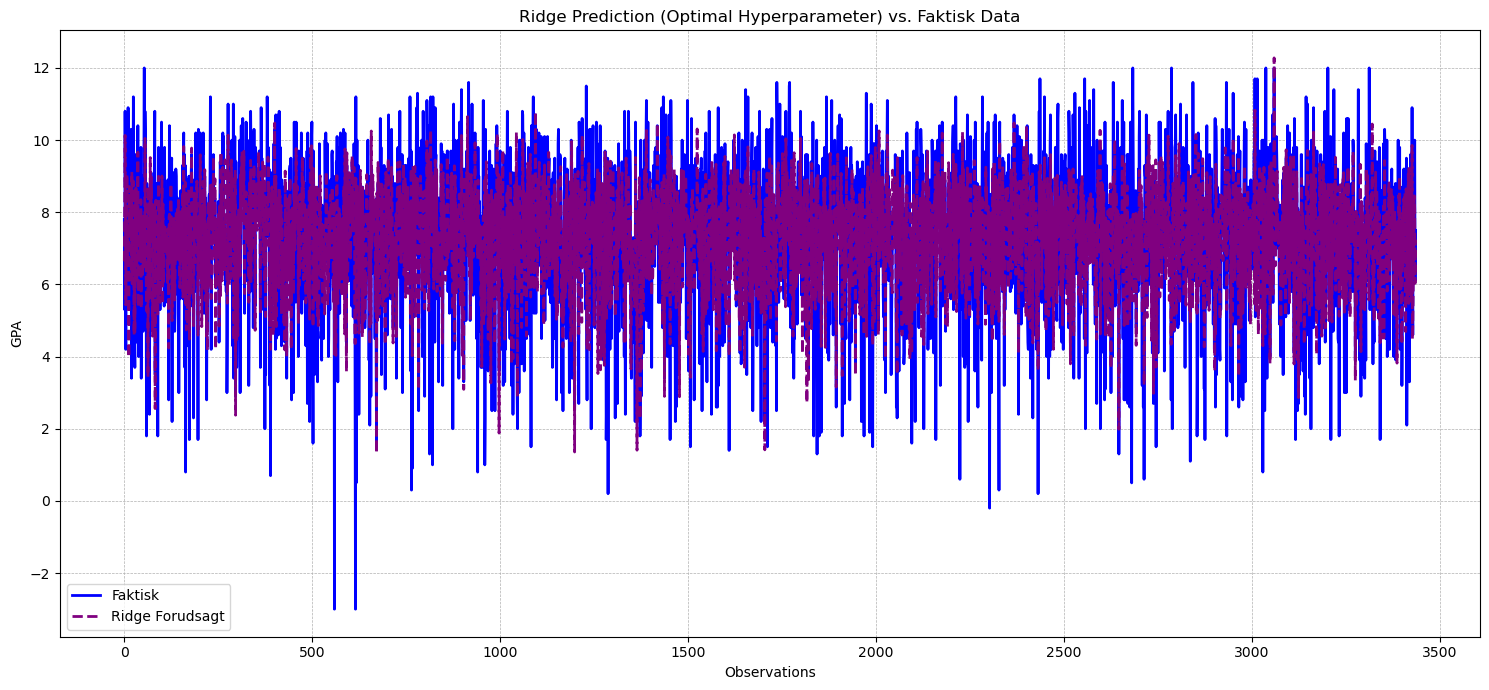

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Opret en række numre for x-aksen baseret på længden af dataene
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Faktisk', color='blue', linewidth=2)
plt.plot(x_axis, predictions_best_grid_Ridge, label='Ridge Forudsagt', color='purple', linestyle='--', linewidth=2)
plt.title('Ridge Prediction (Optimal Hyperparameter) vs. Faktisk Data')
plt.xlabel('Observations')
plt.ylabel('GPA')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Coefficients for Ridge

In [41]:
# Hent koefficienterne fra den optimale Lasso-model
Ridge_coefficients = best_grid_Ridge.coef_

# Opret en DataFrame for bedre læsbarhed
coeff_df_ridge = pd.DataFrame(Ridge_coefficients, Input_values_list, columns=['Coefficient'])

coeff_df_ridge

,Coefficient
credit,-0.013564
movingAverage,0.732486
Tutoring,0.000000
Lectures,-0.094234
Preparation,-0.008423
...,...
Study board_The Study Board for Public Health Science and Global\r\nHealth,0.054390
Study board_The Study Board for Veterinary Medicine and Animal\r\nScience,0.034326
Study board_Økonomisk Studienævn,-0.107586
Censorship form_External censorship,-0.005415


) missing from current font.
  plt.tight_layout()
) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


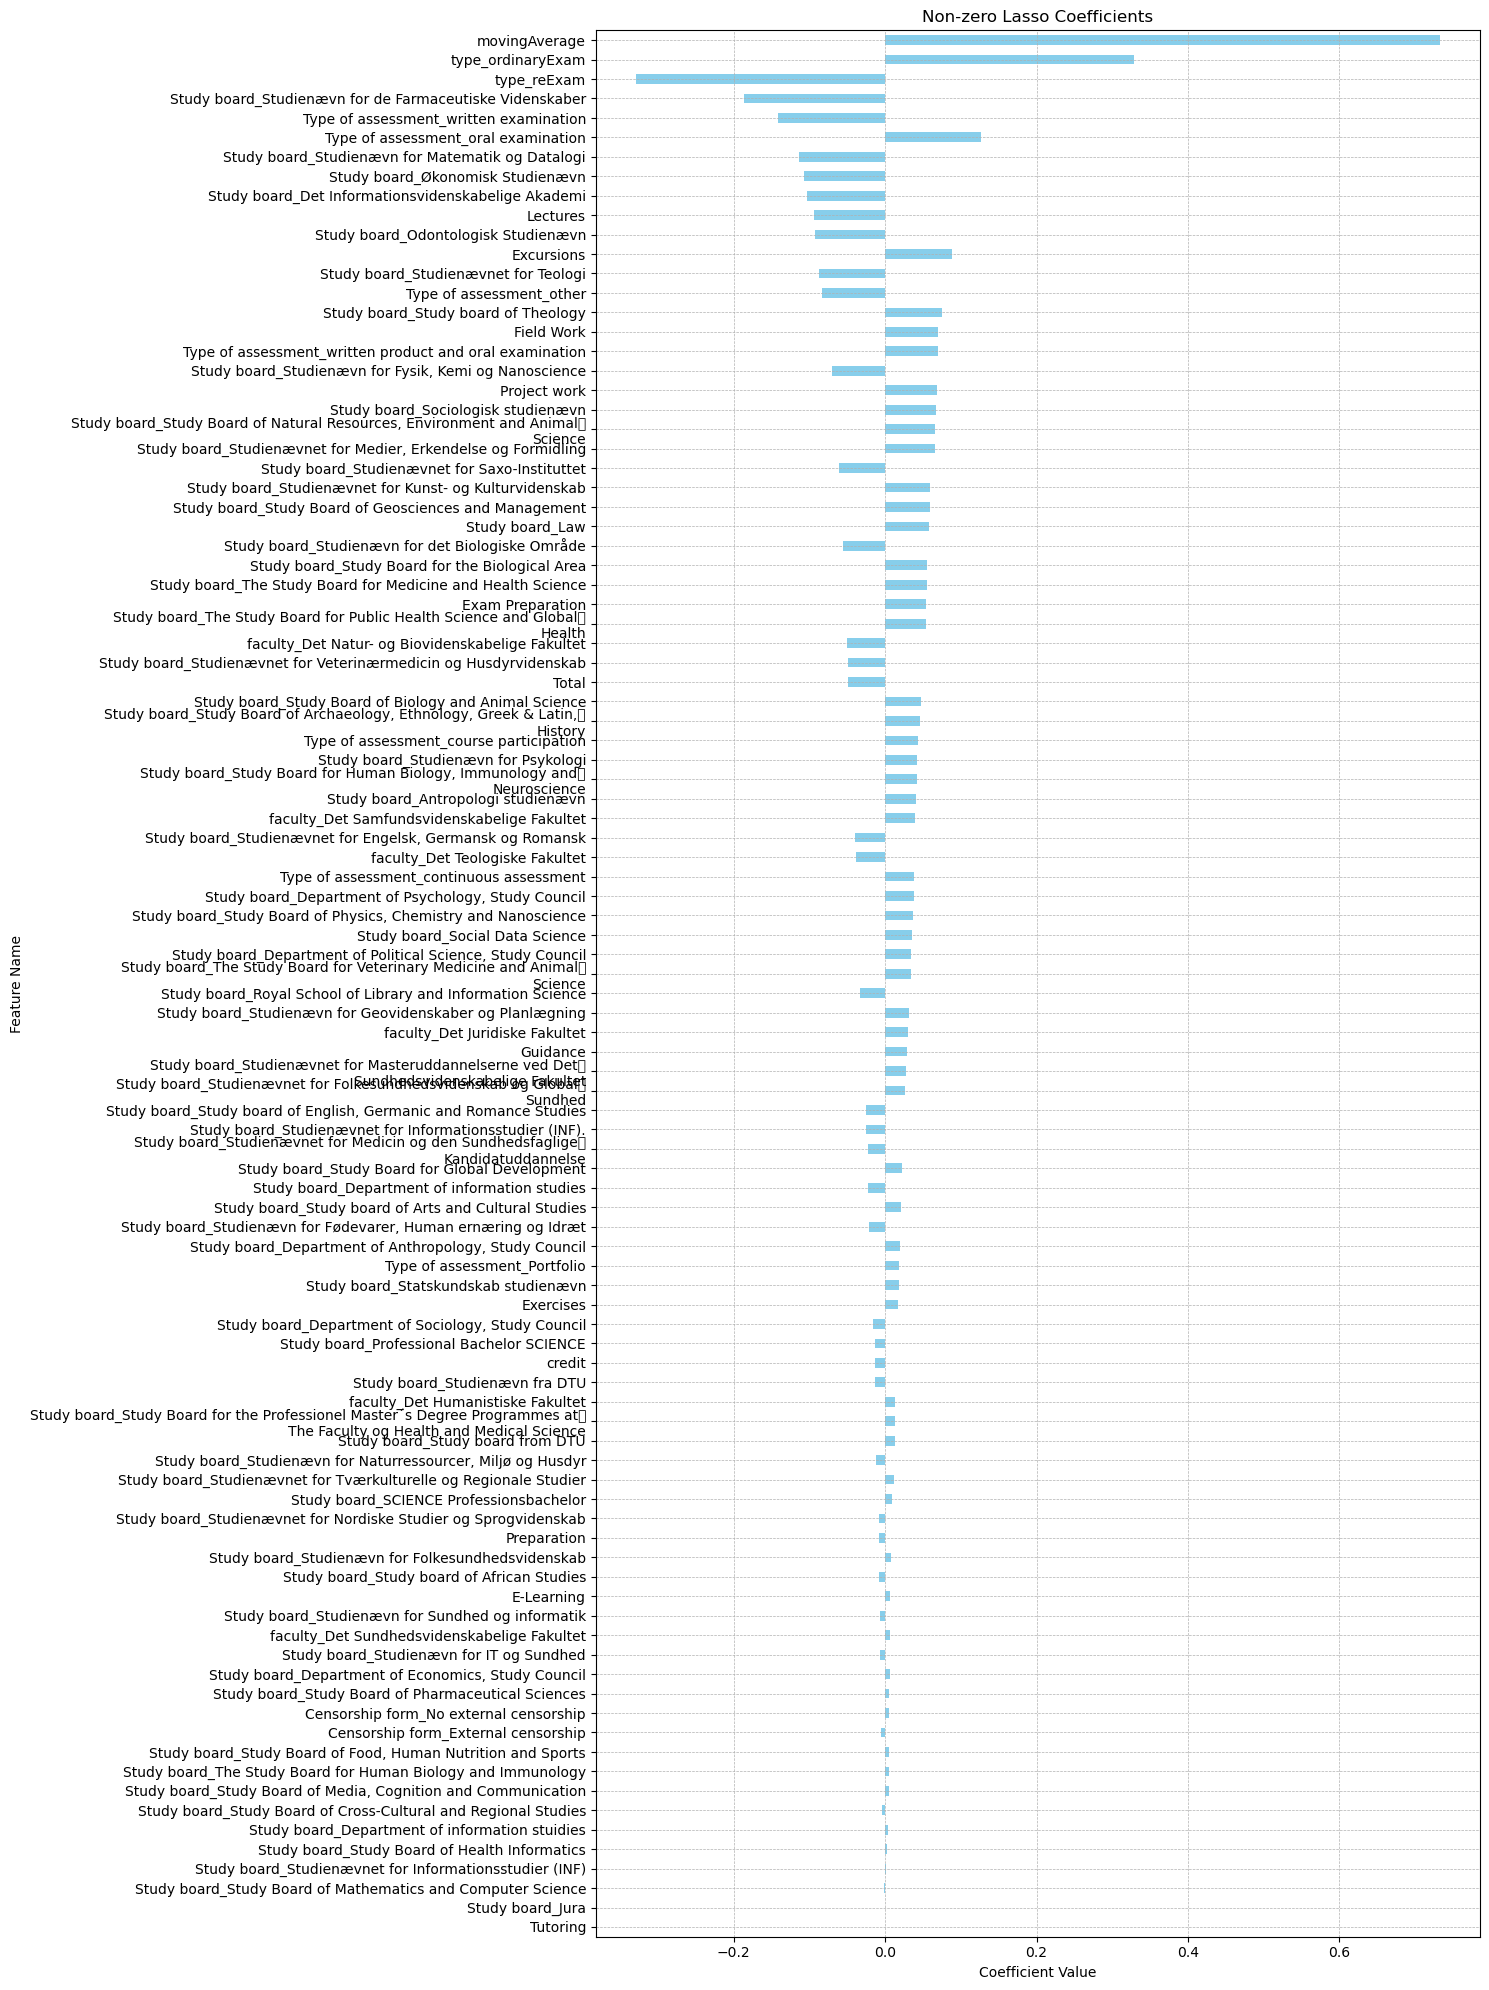

In [42]:
# Filter out zero coefficients
non_zero_coeffs = coeff_df_ridge

# Sort coefficients by absolute value for better visualization
sorted_coeffs = non_zero_coeffs.sort_values(by='Coefficient', key=lambda x: abs(x), ascending=False)

# Plot
plt.figure(figsize=(15,20))
sorted_coeffs['Coefficient'].plot(kind='barh', color='skyblue')
plt.title('Ridge Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis()  # This will display the largest coefficients at the top
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

## Random Forrest Regressor

In [19]:
#Beforehand -finding an baseline prediction to make sure machine learning better the prediction
# The baseline predictions are set to 7 (around average)
baseline_preds = 7
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  1.74


In [20]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=1000, random_state=42)

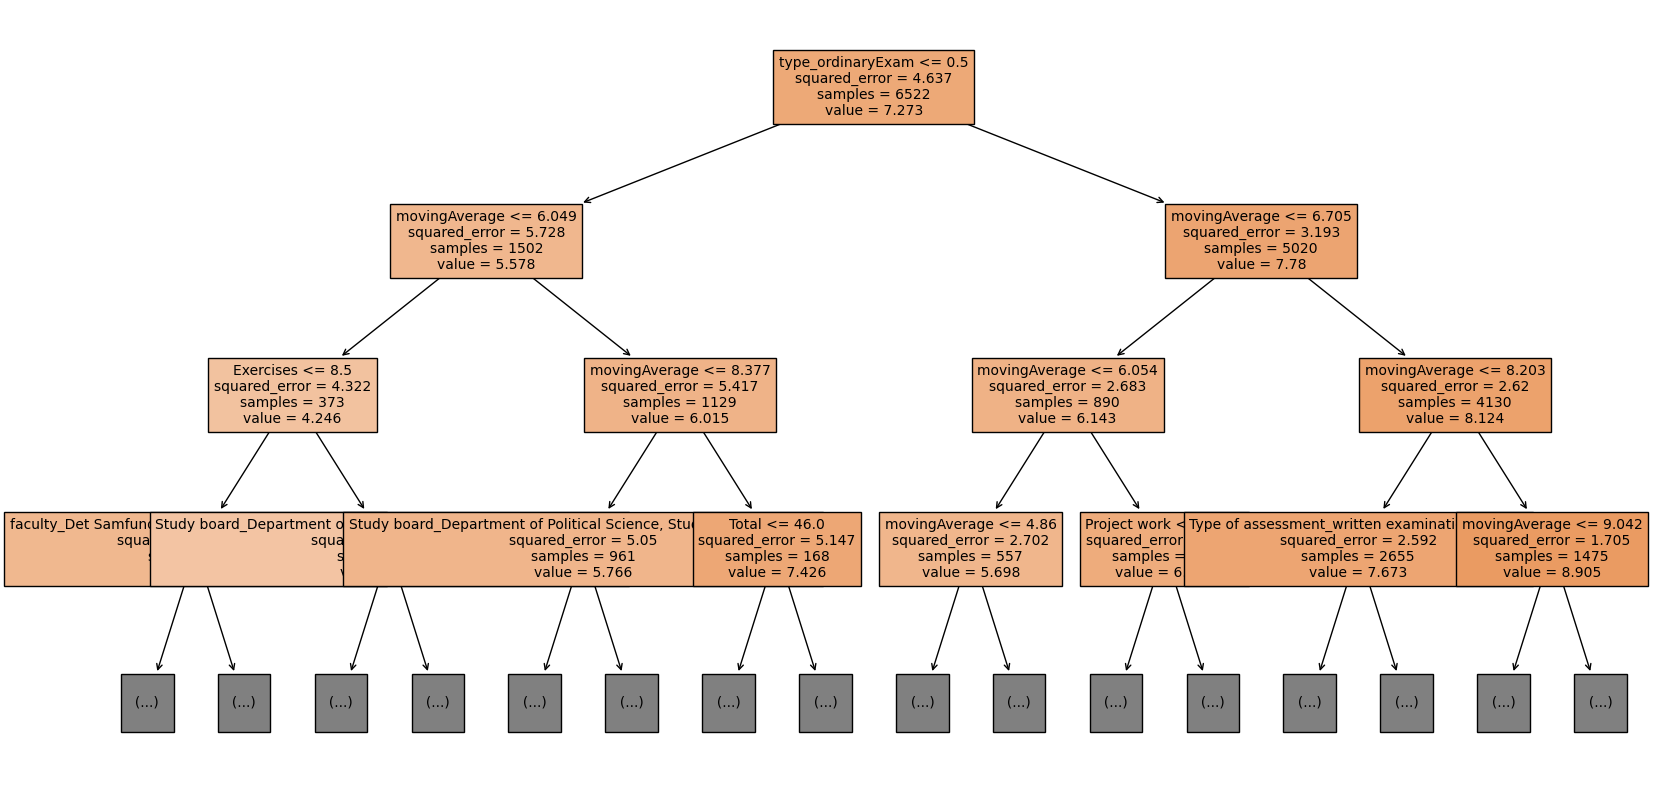

In [21]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Choose a tree from the forrest (in this case the first tree)
tree = rf.estimators_[0]

plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=Input_values_list, max_depth=3, fontsize=10)
plt.show()

In [22]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the accuracy measurements
accuracy(predictions,test_labels)

MAE: 1.19126 grades.
MAPE: 25.15591 %.
Accuracy: 74.84409 %.
MSE: 2.50753


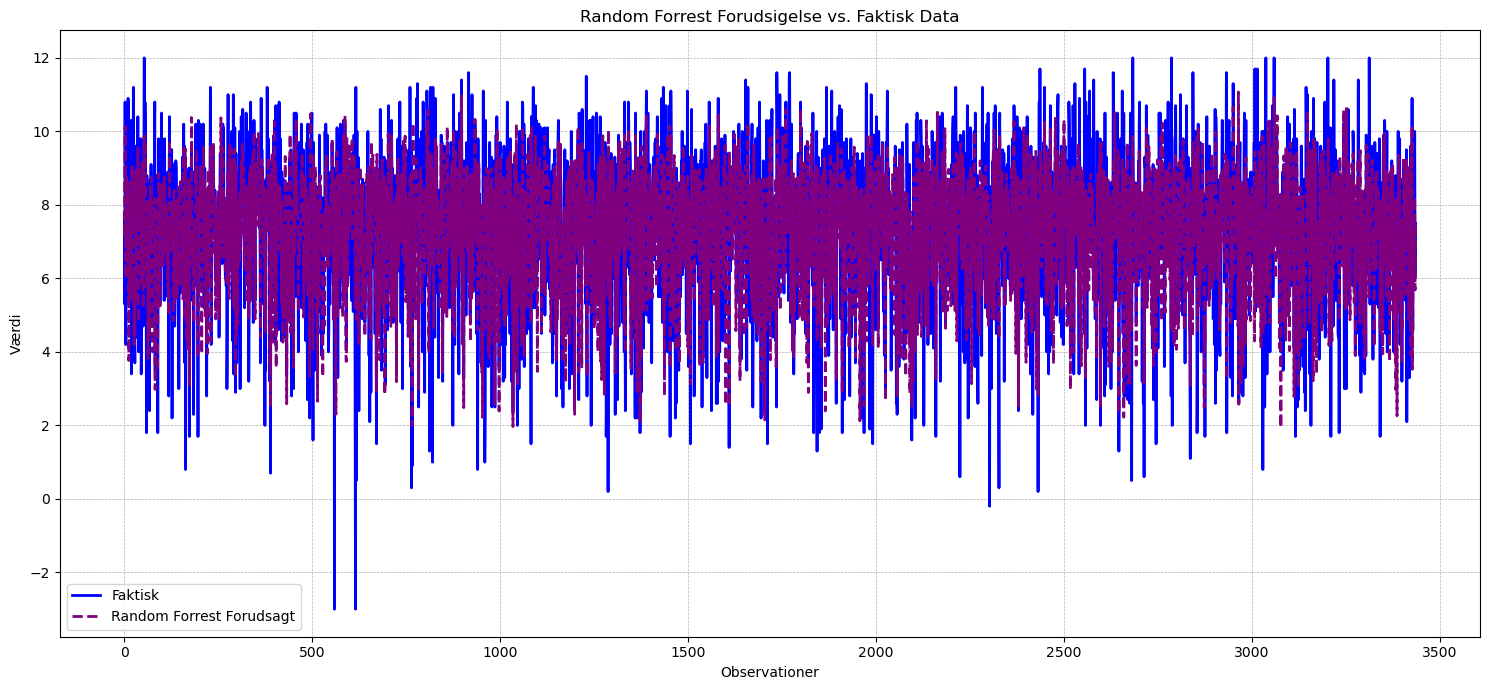

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Opret en række numre for x-aksen baseret på længden af dataene
x_axis = np.arange(len(test_labels))

plt.figure(figsize=(15,7))
plt.plot(x_axis, test_labels, label='Faktisk', color='blue', linewidth=2)
plt.plot(x_axis, predictions, label='Random Forrest Forudsagt', color='purple', linestyle='--', linewidth=2)
plt.title('Random Forrest Forudsigelse vs. Faktisk Data')
plt.xlabel('Observationer')
plt.ylabel('Værdi')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()